## Loading libraries and data

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [31]:
data_dir = 'data'

In [32]:
os.listdir(data_dir) #shows the two classes

['O', 'R']

In [33]:
data = tf.keras.utils.image_dataset_from_directory('data')#building the data pipeline

Found 25077 files belonging to 2 classes.


In [34]:
data_iterator = data.as_numpy_iterator() # with this we can access the data pipeline 
batch = data_iterator.next()
batch # returns a numpy array of 32 images as the batch size is 32

(array([[[[ 55.628906,  60.666016, 115.48047 ],
          [ 49.5625  ,  55.228516, 104.44922 ],
          [ 87.46289 ,  90.46289 , 131.60742 ],
          ...,
          [137.9375  , 143.63867 , 159.7832  ],
          [126.66797 , 138.11133 , 159.66602 ],
          [123.11133 , 138.      , 159.03711 ]],
 
         [[ 76.38024 ,  80.845085, 131.08142 ],
          [ 85.92708 ,  91.14824 , 135.79082 ],
          [ 91.581635,  94.94154 , 131.50795 ],
          ...,
          [135.34778 , 141.98111 , 157.65956 ],
          [129.6556  , 141.22638 , 162.71735 ],
          [129.8511  , 144.73978 , 165.77689 ]],
 
         [[ 80.373726,  84.676636, 126.63154 ],
          [ 95.66216 , 100.231766, 137.1778  ],
          [100.5173  , 103.67853 , 132.91008 ],
          ...,
          [132.2934  , 139.62347 , 154.95355 ],
          [133.41956 , 145.851   , 167.03922 ],
          [139.92879 , 154.84943 , 175.87589 ]],
 
         ...,
 
         [[161.81854 , 171.13211 , 180.13211 ],
          [151.258

### By default the 'dataset_from_directory' takes the 'batch_size' to be 32.. why?
* Because it aligns well with GPU and CPU architectures
* Lower memory utilisation
* Better generalization and stable training

In [35]:
# Class 1 means recylable
# Class 0 means Organic
print(len(batch))
print(batch[1]) # prints the batch labels

2
[0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1]


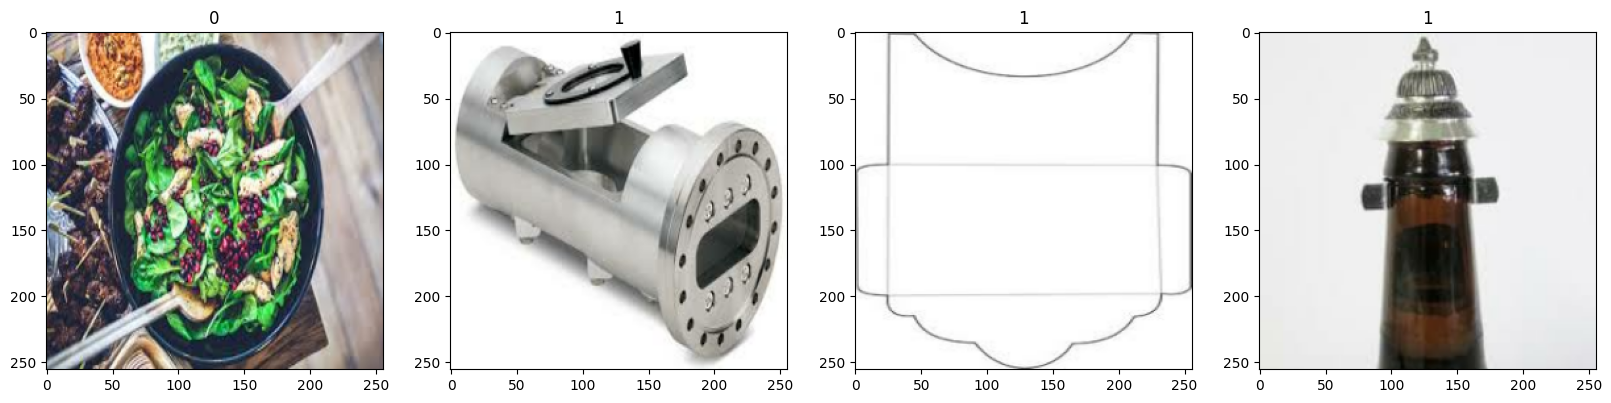

In [36]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [37]:
batch[0].shape 
# means the batch has 32 images of size 256x256 and has 3 channels

(32, 256, 256, 3)

## Why does CNN perform better on binary images?
* No grayscale noise, so CNN can focus better on distinct feature rather than on varying intensities
* Better generalization as the data is less complex and faster training speed
* Reduces overfitting as it only considers the most distinct features of an image

### Data pre-processing for image scaling

In [38]:
data = data.map(lambda x,y : ((x/255), y))
# x is the independent feature and y is the target variable
data

<MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [39]:
scaled_iterator = data.as_numpy_iterator()
batch_scaled = scaled_iterator.next()

In [40]:
print(f'Max intensity of image is {batch_scaled[0].max()} and min is {batch_scaled[0].min()}')
# So we have coverted a 8-bit image to a binary image, that is every pixel is either black or white

Max intensity of image is 1.0 and min is 0.0


### Splitting the data

In [41]:
len(data) #there are 784 batches each consisting of 32 images

784

In [42]:
train_size = int(len(data)*0.7) # 784*0.7 = 548.8 which is 548 because 'int'
test_size = int(len(data)*0.1)+1  # 78 
valid_size = int(len(data)*0.2)+1 # 156

In [43]:
train_size + test_size + valid_size

784

In [44]:
train = data.take(train_size)
val = data.skip(train_size).take(valid_size)
test = data.skip(train_size + valid_size).take(test_size)

#### The 'take' considers the number of batches specified by the train_size and 'skip' skips the already taken batches so we make sure that the same batches present in training are not there in the validation data

#### Similarly the combined batches present in validation and train are not to bee seen by the test data

### CNN model

#### Using the Sequential API because of sinlge input and output tensor
#### Use the Functional API when you need to build models with multiple inputs, multiple outputs, shared layers, or any other complex structure. (no need here because of clear binary classification)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

#### Conv2D - 2D convolution layer for processing 2D spatial data like images
#### MaxPooling2D - Condense this Convolution layer
#### 

In [46]:
model = Sequential()

In [47]:
model.add(Conv2D(16, (3,3), 1, activation = "relu", input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = "relu")) #16 is the number of filters
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01))) #256 neurons and a dense layer
model.add(Dense(1, activation = 'sigmoid')) # output is 0 or 1


#.add adds a new layer to the network
# 16 filters, output will have 16 feature maps
# (3,3) 3x3 matrix that slides over the input image to perform the convolution operation.
# 1 is stride of convolution, the filter moves 1 pixel at a time


#### L2 reguralization with penalty = 0.01 

#### adam optimizer, Binary cross entropy loss

In [48]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

#### Flatten takes the max pooling 2d and converts it into a single dimension, 30x30x16 = 14400 dimension

In [50]:
logdir = 'logs'

In [51]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = logdir)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [52]:
record = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard, early_stopping])

Epoch 1/20
548/548 [==============================] - 74s 133ms/step - loss: 0.5914 - accuracy: 0.8027 - val_loss: 0.4408 - val_accuracy: 0.8406
Epoch 2/20
548/548 [==============================] - 53s 97ms/step - loss: 0.4406 - accuracy: 0.8261 - val_loss: 0.4051 - val_accuracy: 0.8507
Epoch 3/20
548/548 [==============================] - 57s 103ms/step - loss: 0.4151 - accuracy: 0.8387 - val_loss: 0.3931 - val_accuracy: 0.8623
Epoch 4/20
548/548 [==============================] - 56s 103ms/step - loss: 0.3988 - accuracy: 0.8493 - val_loss: 0.3807 - val_accuracy: 0.8573
Epoch 5/20
548/548 [==============================] - 57s 103ms/step - loss: 0.3871 - accuracy: 0.8545 - val_loss: 0.3630 - val_accuracy: 0.8752
Epoch 6/20
548/548 [==============================] - 61s 110ms/step - loss: 0.3805 - accuracy: 0.8595 - val_loss: 0.3592 - val_accuracy: 0.8706
Epoch 7/20
548/548 [==============================] - 62s 113ms/step - loss: 0.3619 - accuracy: 0.8684 - val_loss: 0.3456 - val_acc

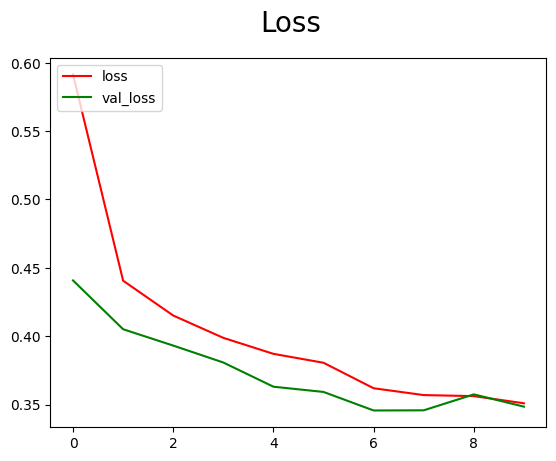

In [54]:
fig = plt.figure()
plt.plot(record.history['loss'], color = 'red', label = 'loss')
plt.plot(record.history['val_loss'], color = 'green', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

### Performance evaluation

In [53]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [69]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()
true_labels = []
predictions = []


In [70]:
for batch in test.as_numpy_iterator(): 
    X, y = batch  
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)
    true_labels.extend(y)
    predictions.extend(np.round(yhat))

1/1 [==============================] - 0s 28ms/step


In [71]:
print(f'Precision : {precision.result()}')
print(f'accuracy : {accuracy.result()}')
print(f'recall : {recall.result()}')

Precision : 0.8538324236869812
accuracy : 0.8820024132728577
recall : 0.8780934810638428


In [81]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, predictions)

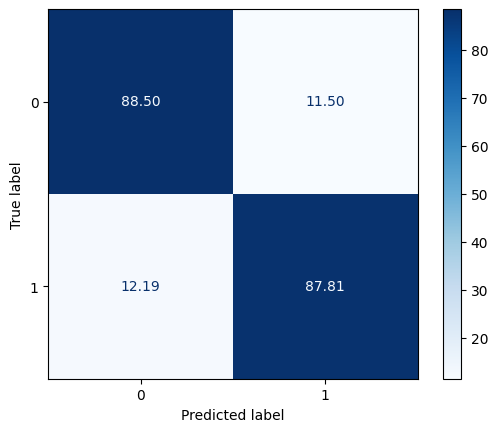

In [83]:
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=np.unique(true_labels))
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")  
plt.show()

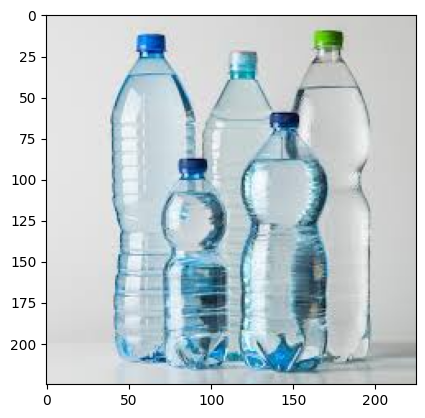

In [93]:
image = cv2.imread('images.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [98]:
resized = tf.image.resize(image, (256,256))

In [99]:
yhat = model.predict(np.expand_dims(resized/255,0))

1/1 [==============================] - 1s 835ms/step


In [103]:
if yhat >= 0.5:
    print('Recycable')
else:
    print('Organic')

Recycable


In [104]:
from tensorflow.keras.models import load_model

In [106]:
model.save(os.path.join('CNNclassifier.h5'))

In [107]:
new_model = load_model(os.path.join('CNNclassifier.h5'))

In [108]:
y_pred = new_model.predict(np.expand_dims(resized/255,0))

1/1 [==============================] - 0s 141ms/step


In [109]:
y_pred

array([[0.56163126]], dtype=float32)